# Inputs

In [1]:
splitPartCount = 5
splitSeed = 27
hoursPerWindow = 1

# Preproccess

## read data

In [2]:
from utils.class_patient import Patients


patients = Patients.loadPatients()
len(patients)

1213

## remove missing

In [3]:
# fill measures whose null represent false value

from constants import NULLABLE_MEASURES


nullableMeasures = NULLABLE_MEASURES

for measureName in nullableMeasures:
    patients.fillMissingMeasureValue(measureName, 0)

In [4]:
# remove measures with less than 80% of data

measures = patients.getMeasures()

for measure, count in measures.items():
    if count < len(patients) * 80 / 100:
        patients.removeMeasures([measure])
        print(measure, count)

pco2 917
ph 954
po2 917
albumin 406
hba1c 326
lymphocyte 446
height 415
urine-ketone 294
crp 19


In [5]:
# remove patients with less than 80% of data

patients.removePatientByMissingFeatures()
len(patients)

1206

In [6]:
# # remove patients with positive tag in first 12 hours

from pandas import Timedelta


patients.removePatientAkiEarly(Timedelta(hours=12))

82

In [7]:
print("Total ", len(patients))
print("AKI ", sum([1 for p in patients if p.akdPositive]))
print("Ratio ", sum([1 for p in patients if p.akdPositive]) / len(patients))

Total  1124
AKI  392
Ratio  0.3487544483985765


## split patients

# LSTM

### Seperate static and dynamic

In [8]:
from keras.models import Sequential, Model
from keras.layers import (
    LSTM,
    Dense,
    Dropout,
    Input,
    Concatenate,
    Masking,
    Conv1D,
    MaxPooling1D,
    BatchNormalization,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow as tf


def createModel2(timeSteps, timeFeatures, staticFeatures):
    # time series layers
    timeInputLayer = Input(shape=(timeSteps, timeFeatures))
    # maskingLayer = Masking(mask_value=0.0)(timeInputLayer)
    # cnnLayer = Conv1D(64, 3, activation="relu", kernel_regularizer=l2(0.01))(maskingLayer)
    # batNormCnn = BatchNormalization()(cnnLayer)
    # poolingLayer = MaxPooling1D(2)(batNormCnn)
    seriesLayer = LSTM(64, return_sequences=True)(timeInputLayer)
    combined = Dropout(0.2)(seriesLayer)
    seriesLayer2 = tf.keras.layers.GlobalAveragePooling1D()(combined)
    seriesDense = Dense(32, activation="relu")(seriesLayer2)

    # static layers
    staticInputLayer = Input(shape=(staticFeatures,))
    staticLayer = Dense(32, activation="relu")(staticInputLayer)

    # combine layers
    combined = Concatenate(axis=1)([seriesDense, staticLayer])
    combined = Dense(16, activation="relu")(combined)
    # combined = Dropout(0.2)(combined)
    # combined = Dense(8, activation="relu")(combined)
    combined = Dropout(0.2)(combined)
    combined = Dense(1, activation="sigmoid")(combined)

    model = Model(inputs=[timeInputLayer, staticInputLayer], outputs=combined)
    model.compile(
        optimizer=Adam(learning_rate=0.00001),
        loss="binary_crossentropy",
        metrics=["AUC", "accuracy", "precision", "recall"],
    )

    return model

2024-09-28 07:24:11.895958: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-28 07:24:11.902229: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-28 07:24:11.908890: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-28 07:24:11.911181: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-28 07:24:11.917102: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
import pickle
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc,
)
from utils.prepare_data import DeepLearningDataPreparer, trainValTestPatients
from utils.class_voter import combineProbas
from constants import TEMP_PATH
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping


accuracy_score_list = []
precision_score_list = []
recall_score_list = []
auc_score_list = []
specificity_score_list = []
sensitivity_score_list = []
auc_pr_list = []

train_loss_list = []
val_loss_list = []

for i, (trainValGenerator, testPatients) in enumerate(
    trainValTestPatients(patients, splitSeed)
):
    models = []
    probas = []
    for ii, (trainPatients, valPatients) in enumerate(trainValGenerator):
        preparer = DeepLearningDataPreparer(
            hoursPerWindows=hoursPerWindow,
            fromHour=0,
            toHour=12,
        )

        cacheFile = TEMP_PATH / f"dl_train_data/{i}_{ii}.pkl"
        cacheFile.parent.mkdir(parents=True, exist_ok=True)

        if cacheFile.exists():
            (
                (npTrainX, staticTrainX, trainY),
                (npValX, staticValX, valY),
                (npTestX, staticTestX, testY),
            ) = pickle.loads(cacheFile.read_bytes())
        else:
            npTrainX, staticTrainX, trainY = preparer.fit_transform(trainPatients)
            npValX, staticValX, valY = preparer.transform(valPatients)
            npTestX, staticTestX, testY = preparer.transform(testPatients)
            cacheFile.write_bytes(
                pickle.dumps(
                    (
                        (npTrainX, staticTrainX, trainY),
                        (npValX, staticValX, valY),
                        (npTestX, staticTestX, testY),
                    )
                )
            )

        neg, pos = np.bincount(trainY)
        weight0 = (1 / neg) * (len(trainY)) / 2.0
        weight1 = (1 / pos) * (len(trainY)) / 2.0
        weight = {0: weight0, 1: weight1}

        early_stopping = EarlyStopping(
            monitor="val_loss", patience=250, restore_best_weights=True
        )

        model = createModel2(npTrainX.shape[1], npTrainX.shape[2], staticTrainX.shape[1])

        history = model.fit(
            [npTrainX, staticTrainX],
            np.array(trainY),
            epochs=5000,
            batch_size=32,
            validation_data=([npValX, staticValX], np.array(valY)),
            class_weight=weight,
            callbacks=[early_stopping],
            verbose=0,
        )
        train_loss_list.append(history.history["loss"])
        val_loss_list.append(history.history["val_loss"])
        probas.append(model.predict([npTestX, staticTestX]))
        # model.save(f"result/lstm_split_model/lstm_split_model_{i}_{ii}.keras")

    # calculate final probas, auc, accuracy, precision, recal
    finalYProbas = np.apply_along_axis(combineProbas, 0, np.array(probas))
    finalYPred = np.where(finalYProbas > 0.5, 1, 0)
    tn, fp, fn, tp = confusion_matrix(testY, finalYPred).ravel()
    precision_vals, recall_vals, _ = precision_recall_curve(testY, finalYProbas)

    accuracy_score_list.append(accuracy_score(testY, finalYPred))
    specificity_score_list.append(tn / (tn + fp))
    precision_score_list.append(precision_score(testY, finalYPred))
    recall_score_list.append(recall_score(testY, finalYPred))
    auc_score_list.append(roc_auc_score(testY, finalYProbas))
    auc_pr_list.append(auc(recall_vals, precision_vals))

In [10]:
print(f"AUC: {np.mean(auc_score_list)} +- {np.std(auc_score_list)}", auc_score_list)
print(f"Accuracy: {np.mean(accuracy_score_list)} +- {np.std(accuracy_score_list)}", accuracy_score_list)
print(f"Specificity: {np.mean(specificity_score_list)} +- {np.std(specificity_score_list)}", specificity_score_list)
print(f"Precision: {np.mean(precision_score_list)} +- {np.std(precision_score_list)}", precision_score_list)
print(f"Recall: {np.mean(recall_score_list)} +- {np.std(recall_score_list)}", recall_score_list)
print(f"AUC PR: {np.mean(auc_pr_list)} +- {np.std(auc_pr_list)}", auc_pr_list)

AUC: 0.793063915174941 +- 0.018534741028044078 [0.8145822431536718, 0.8131868131868132, 0.7763135078897173, 0.7920062424137333, 0.7692307692307693]
Accuracy: 0.7304206349206349 +- 0.01755823194960903 [0.7466666666666667, 0.7555555555555555, 0.7111111111111111, 0.7155555555555555, 0.7232142857142857]
Specificity: 0.7417202497437332 +- 0.028533833831843394 [0.7687074829931972, 0.7755102040816326, 0.7054794520547946, 0.7123287671232876, 0.7465753424657534]
Precision: 0.5963674951764839 +- 0.023331504797406703 [0.6179775280898876, 0.6292134831460674, 0.57, 0.5757575757575758, 0.5888888888888889]
Recall: 0.7091204154495294 +- 0.015996590335452084 [0.7051282051282052, 0.717948717948718, 0.7215189873417721, 0.7215189873417721, 0.6794871794871795]
AUC PR: 0.6582808182923374 +- 0.02163010573369091 [0.6574950484881206, 0.69093661515782, 0.651844244246875, 0.6668646682502514, 0.6242635153186203]


## Equalize sensitivity and specificity

In [ ]:
import pickle
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc,
)
from utils.prepare_data import DeepLearningDataPreparer, trainValTestPatients
from utils.class_voter import combineProbas
from constants import TEMP_PATH
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras


accuracy_score_list = []
precision_score_list = []
recall_score_list = []
auc_score_list = []
specificity_score_list = []
sensitivity_score_list = []
auc_pr_list = []

train_loss_list = []
val_loss_list = []

for i, (trainValGenerator, testPatients) in enumerate(
    trainValTestPatients(patients, splitSeed)
):
    models = []
    probas = []
    for ii, (trainPatients, valPatients) in enumerate(trainValGenerator):
        preparer = DeepLearningDataPreparer(
            hoursPerWindows=hoursPerWindow,
            fromHour=0,
            toHour=12,
        )

        cacheFile = TEMP_PATH / f"dl_train_data/{i}_{ii}.pkl"
        cacheFile.parent.mkdir(parents=True, exist_ok=True)

        if cacheFile.exists():
            (
                (npTrainX, staticTrainX, trainY),
                (npValX, staticValX, valY),
                (npTestX, staticTestX, testY),
            ) = pickle.loads(cacheFile.read_bytes())
        else:
            npTrainX, staticTrainX, trainY = preparer.fit_transform(trainPatients)
            npValX, staticValX, valY = preparer.transform(valPatients)
            npTestX, staticTestX, testY = preparer.transform(testPatients)
            cacheFile.write_bytes(
                pickle.dumps(
                    (
                        (npTrainX, staticTrainX, trainY),
                        (npValX, staticValX, valY),
                        (npTestX, staticTestX, testY),
                    )
                )
            )

        neg, pos = np.bincount(trainY)
        weight0 = (1 / neg) * (len(trainY)) / 2.0
        weight1 = (1 / pos) * (len(trainY)) / 2.0
        weight = {0: weight0, 1: weight1}

        early_stopping = EarlyStopping(
            monitor="val_loss", patience=250, restore_best_weights=True
        )

        # model = createModel2(
        #     npTrainX.shape[1], npTrainX.shape[2], staticTrainX.shape[1]
        # )

        # history = model.fit(
        #     [npTrainX, staticTrainX],
        #     np.array(trainY),
        #     epochs=5000,
        #     batch_size=32,
        #     validation_data=([npValX, staticValX], np.array(valY)),
        #     class_weight=weight,
        #     callbacks=[early_stopping],
        #     verbose=0,
        # )
        # train_loss_list.append(history.history["loss"])
        # val_loss_list.append(history.history["val_loss"])
        
        model = keras.models.load_model(f"result/lstm_split_model/lstm_split_model_{i}_{ii}.keras")
        
        probas.append(model.predict([npTestX, staticTestX]))

    # calculate final probas, auc, accuracy, precision, recal
    finalYProbas = np.apply_along_axis(combineProbas, 0, np.array(probas))

    thresholds = np.arange(0.2, 0.81, 0.01)
    differences = []
    for threshold in thresholds:
        y_pred = (finalYProbas > threshold).astype(int)
        recall = recall_score(testY, y_pred)
        tn, fp, fn, tp = confusion_matrix(testY, y_pred).ravel()
        specificity = tn / (tn + fp)
        differences.append(abs(recall - specificity))

    best_threshold = thresholds[np.argmin(differences)]
    finalYPred = (finalYProbas > best_threshold).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(testY, finalYPred).ravel()
    precision_vals, recall_vals, _ = precision_recall_curve(testY, finalYProbas)

    accuracy_score_list.append(accuracy_score(testY, finalYPred))
    specificity_score_list.append(tn / (tn + fp))
    precision_score_list.append(precision_score(testY, finalYPred))
    recall_score_list.append(recall_score(testY, finalYPred))
    auc_score_list.append(roc_auc_score(testY, finalYProbas))
    auc_pr_list.append(auc(recall_vals, precision_vals))

In [11]:
print(f"AUC: {np.mean(auc_score_list)} +- {np.std(auc_score_list)}", auc_score_list)
print(f"Accuracy: {np.mean(accuracy_score_list)} +- {np.std(accuracy_score_list)}", accuracy_score_list)
print(f"Specificity: {np.mean(specificity_score_list)} +- {np.std(specificity_score_list)}", specificity_score_list)
print(f"Precision: {np.mean(precision_score_list)} +- {np.std(precision_score_list)}", precision_score_list)
print(f"Recall: {np.mean(recall_score_list)} +- {np.std(recall_score_list)}", recall_score_list)
print(f"AUC PR: {np.mean(auc_pr_list)} +- {np.std(auc_pr_list)}", auc_pr_list)

AUC: 0.7928753025621911 +- 0.017608038508650455 [0.8149311006453864, 0.8091749520320949, 0.7741460031212067, 0.7943471475637246, 0.7717773094485423]
Accuracy: 0.7322142857142857 +- 0.0196476970147745 [0.7555555555555555, 0.7466666666666667, 0.7066666666666667, 0.7111111111111111, 0.7410714285714286]
Specificity: 0.7335569844376106 +- 0.02044499246746848 [0.7551020408163265, 0.7482993197278912, 0.7054794520547946, 0.7123287671232876, 0.7465753424657534]
Precision: 0.5950094126353924 +- 0.022208229284556576 [0.6210526315789474, 0.6105263157894737, 0.5656565656565656, 0.5714285714285714, 0.6063829787234043]
Recall: 0.7296981499513147 +- 0.018847036380164342 [0.7564102564102564, 0.7435897435897436, 0.7088607594936709, 0.7088607594936709, 0.7307692307692307]
AUC PR: 0.657035057968495 +- 0.020479469905560946 [0.654740195152968, 0.6879186738902655, 0.6504814609005862, 0.6666603434252725, 0.6253746164733831]


: 

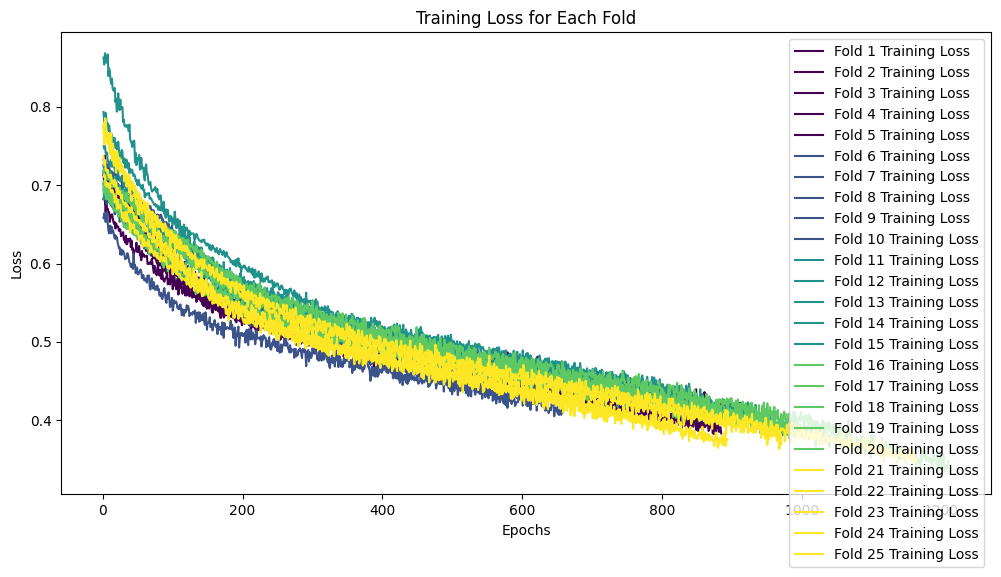

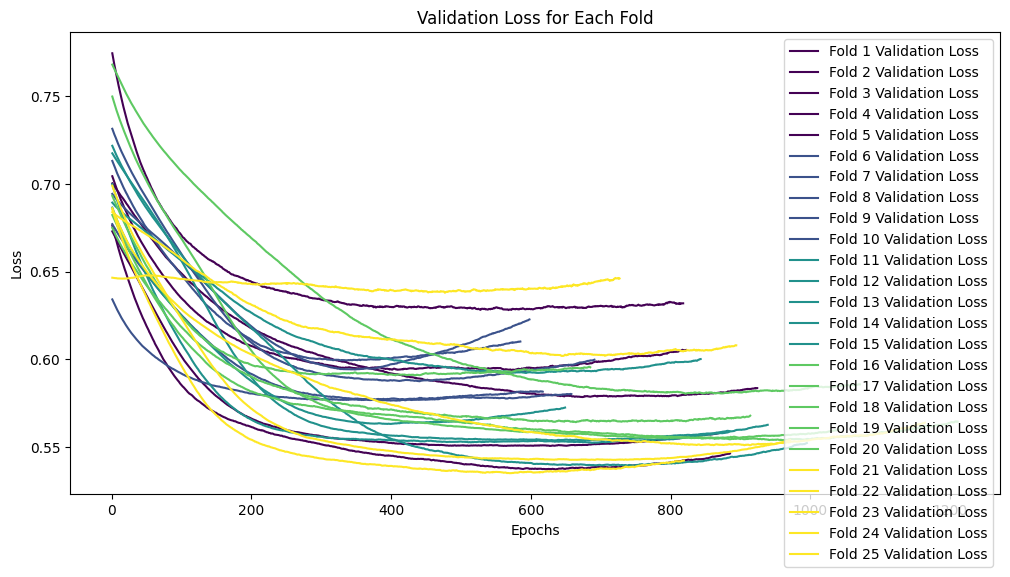

In [11]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm


plt.figure(figsize=(12, 6))

colors = cm.viridis(np.linspace(0, 1, 5))
for i, train_loss in enumerate(train_loss_list):
    plt.plot(
        range(1, len(train_loss) + 1),
        train_loss,
        label=f"Fold {i+1} Training Loss",
        color=colors[i // 5],
    )
plt.title("Training Loss for Each Fold")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("result/lstm_split_train_loss.svg")
plt.show()

# Plot the validation loss for each fold
plt.figure(figsize=(12, 6))
for i, val_loss in enumerate(val_loss_list):
    plt.plot(
        range(1, len(val_loss) + 1),
        val_loss,
        label=f"Fold {i+1} Validation Loss",
        color=colors[i // 5],
    )
plt.title("Validation Loss for Each Fold")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("result/lstm_split_val_loss.svg")
plt.show()